In [1]:
%matplotlib inline
import matplotlib as mlp
mlp.rcParams['figure.dpi'] = 150

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# notebook dependencies
import pandas as pd
# pd.set_option('display.max_rows', None, 'display.max_columns', None)
import numpy as np

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

# math modules
from math import sqrt
import scipy.stats as stats

import acquire
import prepare

# sklearn data science library
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import winsorize

from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [2]:
# import the data
df = acquire.get_bach_df()
df = prepare.clean_college_df(df)

new_df = prepare.avg_net_price(df)
new_df['major_category'] = new_df.major_name.apply(prepare.categorize_major)

# Ensure you have `2017_2018_2019_earning_by_major.csv` within working folder
new_df = prepare.earnings_merge(new_df)
new_df = prepare.create_roi_cols(new_df)

new_df.head()

dataframe shape: (71901, 125)


,unit_id_institution,college_name,institution_control,city,state_post_code,zip_code,share_entering_students_first_ft,share_of_part_time,pred_degree,region_ipeds,...,2017,2018,2019,Grand Total,roi_5yr,pct_roi_5yr,roi_10yr,pct_roi_10yr,roi_20yr,pct_roi_20yr
0,100654.0,Alabama A & M University,Public,Normal,AL,35762,0.8987,0.0587,3.0,5.0,...,57605.68892,55517.86935,61388.93381,174512.4921,0.406166,40.616592,1.989979,198.997868,5.669295,566.929488
1,100654.0,Alabama A & M University,Public,Normal,AL,35762,0.8987,0.0587,3.0,5.0,...,57605.68892,55517.86935,61388.93381,174512.4921,0.406166,40.616592,1.989979,198.997868,5.669295,566.929488
2,100858.0,Auburn University,Public,Auburn,AL,36849,0.7973,0.0791,3.0,5.0,...,57605.68892,55517.86935,61388.93381,174512.4921,0.198891,19.889053,1.549242,154.924194,4.686210,468.620983
3,100858.0,Auburn University,Public,Auburn,AL,36849,0.7973,0.0791,3.0,5.0,...,57605.68892,55517.86935,61388.93381,174512.4921,0.198891,19.889053,1.549242,154.924194,4.686210,468.620983
4,101541.0,Judson College,"Private, nonprofit",Marion,AL,36756,0.7209,0.1622,3.0,5.0,...,57605.68892,55517.86935,61388.93381,174512.4921,0.351246,35.124644,1.873202,187.320152,5.408818,540.881766


In [3]:
# generate a new df for variables i'll be studying

df = new_df[[ 
"college_name",
"institution_control",
"zip_code",
"share_entering_students_first_ft",
"share_of_part_time",
"required_score",
"major_name",
"online_only",
"graduate_number",
"title_IV_student_number",
'other_fam_income_0_30000',
'private_fam_income_0_30000',
'program_fam_income_0_30000',
'pub_fam_income_0_30000',
'other_fam_income_30001_48000',
'private_fam_income_30001_48000',
'program_fam_income_30001_48000',
'pub_fam_income_30001_48000',
'other_fam_income_48001_75000',
'private_fam_income_48001_75000',
'program_fam_income_48001_75000',
'pub_fam_income_48001_75000',
'other_fam_income_75001_110000',
'private_fam_income_75001_110000',
'program_fam_income_75001_110000',
'pub_fam_income_75001_110000',
'other_fam_income_over_110000',
'private_fam_income_over_110000',
'program_fam_income_over_110000',
'pub_fam_income_over_110000',
"deg_percent_awarded_agriculture_operations",
"deg_percent_awarded_natural_resources",
"deg_percent_awarded_architecture",
"deg_percent_awarded_area_ethnic_cultural_gender",
"deg_percent_awarded_communication_journalism",
"deg_percent_awarded_communication_tech",
"deg_percent_awarded_computer_science",
"deg_percent_awarded_personal_culinary_services",
"deg_percent_awarded_education",
"deg_percent_awarded_engineering",
"deg_percent_awarded_engineering_tech",
"deg_percent_awarded_foreign_language_literatures",
"deg_percent_awarded_human_science",
"deg_percent_awarded_legal_profession",
"deg_percent_awarded_english_lang",
"deg_percent_awarded_general_studies",
"deg_percent_awarded_library_sciences",
"deg_percent_awarded_bio_sciences",
"deg_percent_awarded_mathematics",
"deg_percent_awarded_military_tech",
"deg_percent_awarded_intedisciplinary_studies",
"deg_percent_awarded_leisure_fitness",
"deg_percent_awarded_philosophy",
"deg_percent_awarded_theology",
"deg_percent_awarded_physical_sciences",
"deg_percent_awarded_science_tech",
"deg_percent_awarded_psychology",
"deg_percent_awarded_homeland_security",
"deg_percent_awarded_public_admin",
"deg_percent_awarded_social_sciences",
"deg_percent_awarded_construction_trades",
"deg_percent_awarded_mechanic_repair",
"deg_percent_awarded_precision_production",
"deg_percent_awarded_transportation_materials",
"deg_percent_awarded_visual_and_performing_arts",
"deg_percent_awarded_health",
"deg_percent_awarded_business_management",
"deg_percent_awarded_history",
"comp_rt_ft_150over_expected_time_two_races",
"comp_rt_ft_150over_expected_time_native_american",
"comp_rt_ft_150over_expected_time_asian",
"comp_rt_ft_150over_expected_time_black",
"comp_rt_ft_150over_expected_time_hispanic",
"comp_rt_ft_150over_expected_time_non_resident",
"comp_rt_ft_150over_expected_time_unknown_race",
"comp_rt_ft_150over_expected_time_white",
"comp_rt_ft_150over_expected_time",
"enrollment_share_two_races",
"enrollment_share_native_american",
"enrollment_share_asian",
"enrollment_share_black",
"enrollment_share_hispanic",
"enrollment_share_pac_islander",
"enrollment_share_non_resident",
"enrollment_share_unknown",
"enrollment_share_white",
"fedral_loan_full_time_first_time_undergraduate",
"pell_grant_full_time_first_time_undergraduate",
'major_category',
'2017',
'2018',
'2019',
'Grand Total',
'avg_net_price',
'roi_5yr',
'roi_10yr'
]]

# print the shape
df.shape

(71422, 96)

In [4]:
# view the head

df.head()

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,title_IV_student_number,...,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr
0,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, General.",0.0,963.0,NaN,...,0.7143,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,0.406166,1.989979
1,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, Agriculture Operations, and Relat...",0.0,963.0,NaN,...,0.7143,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,0.406166,1.989979
2,Auburn University,Public,36849,0.7973,0.0791,1.0,"Agriculture, General.",0.0,5812.0,NaN,...,0.3039,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,0.198891,1.549242
3,Auburn University,Public,36849,0.7973,0.0791,1.0,Agricultural Production Operations.,0.0,5812.0,NaN,...,0.3039,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,0.198891,1.549242
4,Judson College,"Private, nonprofit",36756,0.7209,0.1622,1.0,Agricultural and Domestic Animal Services.,0.0,NaN,58.0,...,0.7385,0.6000,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,16619.0,0.351246,1.873202


In [5]:
# variables needed for socioeconomic study

# lst = pd.Series(['other_fam_income_0_30000', 'private_fam_income_0_30000', 'program_fam_income_0_30000', 'pub_fam_income_0_30000', 'other_fam_income_30001_48000', 'private_fam_income_30001_48000', 'program_fam_income_30001_48000', 'pub_fam_income_30001_48000', 'other_fam_income_48001_75000', 'private_fam_income_48001_75000', 'program_fam_income_48001_75000', 'pub_fam_income_48001_75000', 'other_fam_income_75001_110000', 'private_fam_income_75001_110000', 'program_fam_income_75001_110000', 'pub_fam_income_75001_110000', 'other_fam_income_over_110000', 'private_fam_income_over_110000', 'program_fam_income_over_110000', 'pub_fam_income_over_110000'])
# lst.tolist()

In [6]:
# collapse avg net price to one column

def avg_net_price(df):

    '''Function that creates a new 'average net price' column from 
    existing avg net public and private columns.
    
    This function takes in a dataframe and re-labels null values as 0 in order
    to add across the two avg net price observations.'''

    df['avg_net_price_public'] = df['avg_net_price_public'].fillna(0)

    df['avg_net_price_private'] = df['avg_net_price_private'].fillna(0)

    df['avg_net_price'] = df.avg_net_price_public + df.avg_net_price_private

    # return the dataframe
    return df

In [7]:
# income brackets

income_0_30000 = [
'other_fam_income_0_30000',
 'private_fam_income_0_30000',
 'program_fam_income_0_30000',
 'pub_fam_income_0_30000']

income_30001_48000 = [
 'other_fam_income_30001_48000',
 'private_fam_income_30001_48000',
 'program_fam_income_30001_48000',
 'pub_fam_income_30001_48000']

income_48001_75000 = [
'other_fam_income_48001_75000',
'private_fam_income_48001_75000',
'program_fam_income_48001_75000',
'pub_fam_income_48001_75000']

income_75001_110000 = [
'other_fam_income_75001_110000',
'private_fam_income_75001_110000',
'program_fam_income_75001_110000',
'pub_fam_income_75001_110000']

income_over_110000 = [
'other_fam_income_over_110000',
'private_fam_income_over_110000',
'program_fam_income_over_110000',
'pub_fam_income_over_110000']

In [8]:
# used as reference

def get_fam_income_col(df, s1, s2, s3, s4):

    '''Function that creates a new 'average net price' column from 
    existing avg net public and private columns.
    
    This function takes in a dataframe and re-labels null values as 0 in order
    to add across the two avg net price observations.'''

    df[s1] = df[s1].fillna(0)

    df[s2] = df[s2].fillna(0)

    df[s3] = df[s3].fillna(0)

    df[s4] = df[s4].fillna(0)

    df['family_income_0_30000'] = df[s1] + df[s2] + df[s3] + df[s4]

    # drop redundant columns
    df = df.drop(columns = [s1, s2, s3, s4])

    # return the dataframe
    return df

In [9]:
# create a "collapse" cols function

def get_fam_income_col(df, col_lst, new_col_string):

    '''Function that creates a new family income columns from 
    existing dummy columns.'''

    df[col_lst] = df[col_lst].fillna(0)

    df[new_col_string] = df[col_lst].sum(axis = 1)

    # drop redundant columns
    df = df.drop(df[col_lst], axis = 1)

    # return the dataframe
    return df

In [10]:
df.shape

(71422, 96)

In [11]:
# splitting the dataset

s1 = 'other_fam_income_0_30000'
s2 = 'private_fam_income_0_30000'
s3 = 'program_fam_income_0_30000'
s4 = 'pub_fam_income_0_30000'

df = get_fam_income_col(df, income_0_30000, "fam_income_0_30000")
df.head()

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,title_IV_student_number,...,pell_grant_full_time_first_time_undergraduate,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000
0,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, General.",0.0,963.0,NaN,...,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,0.406166,1.989979,375.0
1,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, Agriculture Operations, and Relat...",0.0,963.0,NaN,...,0.7057,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,14444.0,0.406166,1.989979,375.0
2,Auburn University,Public,36849,0.7973,0.0791,1.0,"Agriculture, General.",0.0,5812.0,NaN,...,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,0.198891,1.549242,254.0
3,Auburn University,Public,36849,0.7973,0.0791,1.0,Agricultural Production Operations.,0.0,5812.0,NaN,...,0.1409,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,23696.0,0.198891,1.549242,254.0
4,Judson College,"Private, nonprofit",36756,0.7209,0.1622,1.0,Agricultural and Domestic Animal Services.,0.0,NaN,58.0,...,0.6000,Agriculture,57605.68892,55517.86935,61388.93381,174512.4921,16619.0,0.351246,1.873202,20.0


In [12]:
# check the shape

df.shape # checks out

(71422, 93)

In [13]:
# running function for remaining fam_income_variables

# list of cols to collapse
frames = [
    income_30001_48000, 
    income_48001_75000, 
    income_75001_110000, 
    income_over_110000]

# list of new col names
var_names = [
    'income_30001_48000', 
    'income_48001_75000', 
    'income_75001_110000', 
    'income_over_110000']

for i in range(len(frames)):
    var_name = var_names[i]
    df = get_fam_income_col(df, frames[i], var_name)

print(df.shape)
df.head()

(71422, 81)


,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,title_IV_student_number,...,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
0,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, General.",0.0,963.0,NaN,...,61388.93381,174512.4921,14444.0,0.406166,1.989979,375.0,113.0,61.0,27.0,16.0
1,Alabama A & M University,Public,35762,0.8987,0.0587,1.0,"Agriculture, Agriculture Operations, and Relat...",0.0,963.0,NaN,...,61388.93381,174512.4921,14444.0,0.406166,1.989979,375.0,113.0,61.0,27.0,16.0
2,Auburn University,Public,36849,0.7973,0.0791,1.0,"Agriculture, General.",0.0,5812.0,NaN,...,61388.93381,174512.4921,23696.0,0.198891,1.549242,254.0,155.0,166.0,201.0,364.0
3,Auburn University,Public,36849,0.7973,0.0791,1.0,Agricultural Production Operations.,0.0,5812.0,NaN,...,61388.93381,174512.4921,23696.0,0.198891,1.549242,254.0,155.0,166.0,201.0,364.0
4,Judson College,"Private, nonprofit",36756,0.7209,0.1622,1.0,Agricultural and Domestic Animal Services.,0.0,NaN,58.0,...,61388.93381,174512.4921,16619.0,0.351246,1.873202,20.0,10.0,10.0,10.0,8.0


In [14]:
# checking percentage of nulls across features
null_percentages = df.isnull().mean().round(2)

with pd.option_context('display.max_rows', None):
    print(null_percentages)

college_name                                        0.00
institution_control                                 0.00
zip_code                                            0.04
share_entering_students_first_ft                    0.06
share_of_part_time                                  0.04
required_score                                      0.14
major_name                                          0.00
online_only                                         0.04
graduate_number                                     0.17
title_IV_student_number                             0.47
deg_percent_awarded_agriculture_operations          0.04
deg_percent_awarded_natural_resources               0.04
deg_percent_awarded_architecture                    0.04
deg_percent_awarded_area_ethnic_cultural_gender     0.04
deg_percent_awarded_communication_journalism        0.04
deg_percent_awarded_communication_tech              0.04
deg_percent_awarded_computer_science                0.04
deg_percent_awarded_personal_cu

In [15]:
 # create list to collapse by genre
 
# deg_lst = list(null_percentages.iloc[null_percentages.index.str.startswith("deg_percent_awarded_")].index)

In [16]:
# check the shape

df.shape

(71422, 81)

In [17]:
# dropping title_IV_student_number which has a significantly high percentage of missing values/records

df = df.drop(columns = "title_IV_student_number")
df.shape

(71422, 80)

In [18]:
# split the data function

def split_data(df):
    
    train_and_validate, test = train_test_split(
                                                df, 
                                                test_size = 0.2, 
                                                random_state = 123,
                                                stratify = df["major_category"])

    train, validate = train_test_split(
                                    train_and_validate,
                                    test_size = 0.3,
                                    random_state = 123,
                                    stratify = train_and_validate["major_category"])

    print(f'train shape: {train.shape}')
    print(f'validate shape: {validate.shape}')
    print(f'test shape: {test.shape}')

    return train, validate, test

In [19]:
# splitting the data

train, validate, test = split_data(df)

train shape: (39995, 80)
validate shape: (17142, 80)
test shape: (14285, 80)


In [20]:
# recheck nulls

null_percentages = train.isnull().mean().round(2)

with pd.option_context('display.max_rows', None):
    print(null_percentages)# identify columns with > 10% missing records

college_name                                        0.00
institution_control                                 0.00
zip_code                                            0.04
share_entering_students_first_ft                    0.06
share_of_part_time                                  0.04
required_score                                      0.14
major_name                                          0.00
online_only                                         0.04
graduate_number                                     0.17
deg_percent_awarded_agriculture_operations          0.04
deg_percent_awarded_natural_resources               0.04
deg_percent_awarded_architecture                    0.04
deg_percent_awarded_area_ethnic_cultural_gender     0.04
deg_percent_awarded_communication_journalism        0.04
deg_percent_awarded_communication_tech              0.04
deg_percent_awarded_computer_science                0.04
deg_percent_awarded_personal_culinary_services      0.04
deg_percent_awarded_education  

In [21]:
# identify features with greater than 10% missing records

# container = []

# for i in range(len(null_percentages.values)):
#     if null_percentages[i] > .1:

#         container.append(null_percentages.index[i])

# container

In [22]:
# check percentage of nulls for numerical columns

# check_nulls = train[train.select_dtypes(include = "number").columns]

In [23]:
# retrieving numerical column lower/upper bound outliers
# with pd.option_context('display.max_rows', None):

pd.set_option('display.max_rows', None)

def get_outliers_table(df, k = 1.5):
    '''Function to loop through dataframe and return
    continuous variable outliers outside of Q1 and Q3 using of an IQR method.'''

    l1 = df.select_dtypes(include = "number").columns.tolist()

     # dont learn from these variables
    target_lst = [ 
        "roi_5yr",
        "roi_10yr",
        "roi_20yr",
        "pct_roi_5yr",
        "pct_roi_10yr",
        "pct_roi_20yr"
        "2017",                                               
        "2018",                                                   
        "2019",
        "Grand Total",
        "avg_net_price"
        ]
    
    # include non-target 
    num_lst = [col for col in l1 if col not in target_lst]

    holder = []

    # determining continuous features/columns
    for col in train[num_lst]:
        
        # determing 1st and 3rd quartile
        q1, q3 = train[col].quantile([.25, 0.75])
        
        # calculate interquartile range
        iqr = q3 - q1
        
        # set feature/data lower bound limit
        lower_bound = q1 - k * iqr

        # set feature/data upperbound limit
        upper_bound = q3 + k * iqr
        
        metrics = { 
            
            "column": col,
            "column type": train[col].dtype,
            "iqr": round(iqr, 5),
            "lower_bound": round(lower_bound, 5),
            "lower_outliers": len(train[train[col] < lower_bound]),
            "upper_bound": round(upper_bound, 5),
            "upper_outliers": len(train[train[col] > upper_bound])
        }

        holder.append(metrics)

    num_outliers = pd.DataFrame(holder)
    num_outliers = num_outliers.sort_values(by = [ "upper_outliers", "lower_outliers"], ascending = False)

    return num_outliers

num_outliers = get_outliers_table(train)

In [24]:
# ls1 = num_outliers[(num_outliers["lower_outliers"] == 0) & (num_outliers["upper_outliers"] == 0)].index
# ls2 = num_outliers[(num_outliers["lower_bound"] == 0) & (num_outliers["upper_bound"] == 0)].index
# ls3 = num_outliers[(num_outliers["lower_bound"] == 1) & (num_outliers["upper_bound"] == 1)].index


# num_outliers = num_outliers.drop(ls1)
# num_outliers = num_outliers.drop(ls2)
# num_outliers = num_outliers.drop(ls3)
# num_outliers

In [25]:
# performed capping method: Scipy Winsorize method

def percentile_capping(df, low_end, high_end):
    '''Function that uses scipy's winsorize method to cap
    continuous variables at lower and higher end based on a passed 
    percentile values.'''

    l1 = df.select_dtypes(include = "number").columns.tolist()

    # dont include target variables to cap
    target_lst = [ 
        "roi_5yr",
        "roi_10yr",
        "roi_20yr",
        "pct_roi_5yr",
        "pct_roi_10yr",
        "pct_roi_20yr"
        "2017",                                               
        "2018",                                                   
        "2019",
        "Grand Total",
        "avg_net_price"]

    col_lst = [col for col in l1 if col not in target_lst]

    for col in col_lst:

        stats.mstats.winsorize(
            a = df[col], 
            limits = (low_end, high_end), 
            inplace = True)

In [26]:
# test out the function

percentile_capping(train, 0.1, 0.1)
train.shape

(39995, 80)

In [27]:
# inspect the functions worked
# target_lst = [ 
#                 "roi_5yr",
#                 "roi_10yr",
#                 "2017",                                               
#                 "2018",                                                   
#                 "2019",
#                 "Grand Total",
#                 "avg_net_price"]

# num_outiers = [col for col in num_outliers if col not in target_lst]

# ls1 = num_outliers[(num_outliers["lower_outliers"] == 0) & (num_outliers["upper_outliers"] == 0)].index
# ls2 = num_outliers[(num_outliers["lower_bound"] == 0) & (num_outliers["upper_bound"] == 0)].index
# ls3 = num_outliers[(num_outliers["lower_bound"] == 1) & (num_outliers["upper_bound"] == 1)].index


# num_outliers = num_outliers.drop(ls1)
# num_outliers = num_outliers.drop(ls2)
# num_outliers = num_outliers.drop(ls3)

# num_outliers

In [28]:
# capping outliers

def handle_outliers(df, k = 1.5):
    '''Function determines outliers based on "iqr" and then handles outliers
    by transforming these observations to the mean.'''

    l1 = df.select_dtypes(include = "number").columns.tolist()

     # dont learn from these variables
    target_lst = [ 
                "roi_5yr",
                "roi_10yr",
                "2017",                                               
                "2018",                                                   
                "2019",
                "Grand Total",
                "avg_net_price"
        ]
    
    # include non-target 
    num_lst = [col for col in l1 if col not in target_lst]

    # determining continuous features/columns
    for col in df[num_lst]:
        
        # determing 1st and 3rd quartile
        q1, q3 = df[col].quantile([.25, 0.75])
        
        # calculate interquartile range
        iqr = q3 - q1
        
        # set feature/data lower bound limit
        lower_bound = q1 - k * iqr

        # set feature/data upperbound limit
        upper_bound = q3 + k * iqr
        
        # avg value
        avg_value = df[col].mean()

        # cap/convert outliers to upperbound
        df[col] = df[col].apply(lambda x: avg_value if x < lower_bound else x)

        # cap/convert outliers to upperbound
        df[col] = df[col].apply(lambda x: avg_value if x > upper_bound else x)
    
        # renaming the column to reflect capping
        # df.rename(columns = {col: col + "_transformed"}, inplace = True)

    # returning the updated dataframe
    return df

In [29]:
# capping records at lower and upper bounds
# train = handle_outliers(train)
# num_outliers = get_outliers_table(train)

# # inspect the functions worked
# num_outliers

In [30]:
# capping validate and test dfs

percentile_capping(validate, 0.1, 0.1)
percentile_capping(test, 0.1, 0.1)

In [31]:
# create the imputer

def train_iterative_imputer(train_df):

        # placeholder for continuous features
        l1 = train_df.select_dtypes(include = "number").columns.tolist()

        # dont learn from these variables
        target_lst = [ 
        "roi_5yr",
        "roi_10yr",
        "roi_20yr",
        "pct_roi_5yr",
        "pct_roi_10yr",
        "pct_roi_20yr"
        "2017",                                               
        "2018",                                                   
        "2019",
        "Grand Total",
        "avg_net_price"
        ]
        
        num_lst = [col for col in l1 if col not in target_lst]
        
        # creating the "thing"
        imputer = IterativeImputer(
                missing_values = np.nan, \
                skip_complete = True, \
                random_state = 123)
        
        # fitting the "thing" and transforming it
        imputed = imputer.fit_transform(train_df[num_lst])

        # create a new dataframe with learned imputed data
        train_df_imputed = pd.DataFrame(imputed, index = train_df.index)

        # filling in missing values from learned imputer
        train_df[num_lst] = train_df_imputed

        # return the new imputed df
        return train_df

In [32]:
# handling remaining null values using sklearn's iterative imputer

train_imputed = train_iterative_imputer(train)
print(f'df shape: {train_imputed.shape}')
# retuning remaining nulls
remaining_nulls = train_imputed.isnull().sum()

with pd.option_context('display.max_rows', None):
    print(remaining_nulls) # zip codes still missing

df shape: (39995, 80)
college_name                                           0
institution_control                                    0
zip_code                                            1642
share_entering_students_first_ft                       0
share_of_part_time                                     0
required_score                                         0
major_name                                             0
online_only                                            0
graduate_number                                        0
deg_percent_awarded_agriculture_operations             0
deg_percent_awarded_natural_resources                  0
deg_percent_awarded_architecture                       0
deg_percent_awarded_area_ethnic_cultural_gender        0
deg_percent_awarded_communication_journalism           0
deg_percent_awarded_communication_tech                 0
deg_percent_awarded_computer_science                   0
deg_percent_awarded_personal_culinary_services         0
deg_perce

In [33]:
# impute zip codes by mode

train_imputed["zip_code"] = train_imputed["zip_code"].fillna(train_imputed["zip_code"].mode()[0])
print(f'zip_code missing values: {train_imputed.zip_code.isnull().sum()}') # checks out

zip_code missing values: 0


In [34]:
# can do the same across validate and test datasets

def impute_val_and_test(train_df, val_df, test_df):
        
        '''Function takes in all three split datasets and imputes missing values in validate and test after
        fitting on training dataset columns.'''

        l1 = train_df.select_dtypes(include = "number").columns.tolist()

        target_lst = [ 
        "roi_5yr",
        "roi_10yr",
        "roi_20yr",
        "pct_roi_5yr",
        "pct_roi_10yr",
        "pct_roi_20yr"
        "2017",                                               
        "2018",                                                   
        "2019",
        "Grand Total",
        "avg_net_price"
        ]

        # recheck cols are not in target list
        num_lst = [col for col in l1 if col not in target_lst]

        # creating the sklearn imputer
        imputer = IterativeImputer(
                missing_values = np.nan, \
                skip_complete = True, \
                random_state = 123)

        # fitting the imputer
        imputed = imputer.fit(train_df[num_lst])

        # transforming values
        val_imputed = imputed.transform(val_df[num_lst])
        X_validate_imputed = pd.DataFrame(val_imputed, index = val_df.index)
        val_df[num_lst] = X_validate_imputed
        validate_imputed = val_df

        test_imputed = imputed.transform(test_df[num_lst])
        test_imputed = pd.DataFrame(test_imputed, index = test_df.index)
        test_df[num_lst] = test_imputed
        test_imputed = test_df

        # fill-in any instances of missing zip-code values
        validate_imputed["zip_code"] = validate_imputed["zip_code"].fillna(validate_imputed["zip_code"].mode()[0])
        test_imputed["zip_code"] = test_imputed["zip_code"].fillna(test_imputed["zip_code"].mode()[0])


        # returning the imputed validate and test datasets
        return validate_imputed, test_imputed

In [35]:
# look at train

print(f'train shape: {train.shape}')
train.head()

train shape: (39995, 80)


,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,deg_percent_awarded_agriculture_operations,...,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
25530,University of Memphis,Public,38152,0.6227,0.2274,1.0,Journalism.,0.0,4225.0,0.0000,...,58348.57445,169831.2865,13048.0,0.391327,1.937021,559.0,300.0,248.0,186.0,209.0
53875,Limestone University,"Private, nonprofit",29340-3799,0.5654,0.2116,1.0,Communication and Media Studies.,0.0,106.0,0.0000,...,66997.75002,191767.4743,24083.0,0.305598,1.770293,106.0,51.0,57.0,39.0,49.0
42932,Texas State University,Public,78666,0.6166,0.1797,1.0,Design and Applied Arts.,0.0,4457.0,0.0122,...,53039.54507,152893.5207,14692.0,0.219152,1.581241,559.0,300.0,303.0,274.0,471.0
45495,Judson University,"Private, nonprofit",60123-1498,0.4673,0.3243,1.0,Accounting and Related Services.,0.0,222.0,0.0000,...,79608.39225,231146.3982,20498.0,0.658489,2.503619,28.0,16.0,37.0,29.0,28.0
25003,Yeshiva University,"Private, nonprofit",10033-3299,0.9601,0.0183,1.0,"Classics and Classical Languages, Literatures,...",0.0,3751.0,0.0000,...,58348.57445,169831.2865,36414.0,-0.039357,1.027869,58.0,26.0,34.0,34.0,97.0


In [36]:
# impute missing values in validate and test 

validate_imputed, test_imputed = impute_val_and_test(train, validate, test)
print(f'validate shape: {validate_imputed.shape}')
print(f'test shape: {test_imputed.shape}')

validate shape: (17142, 80)
test shape: (14285, 80)


----
### ``Target Variable Distribution``

5 YEAR ROI 

10 YEAR ROI

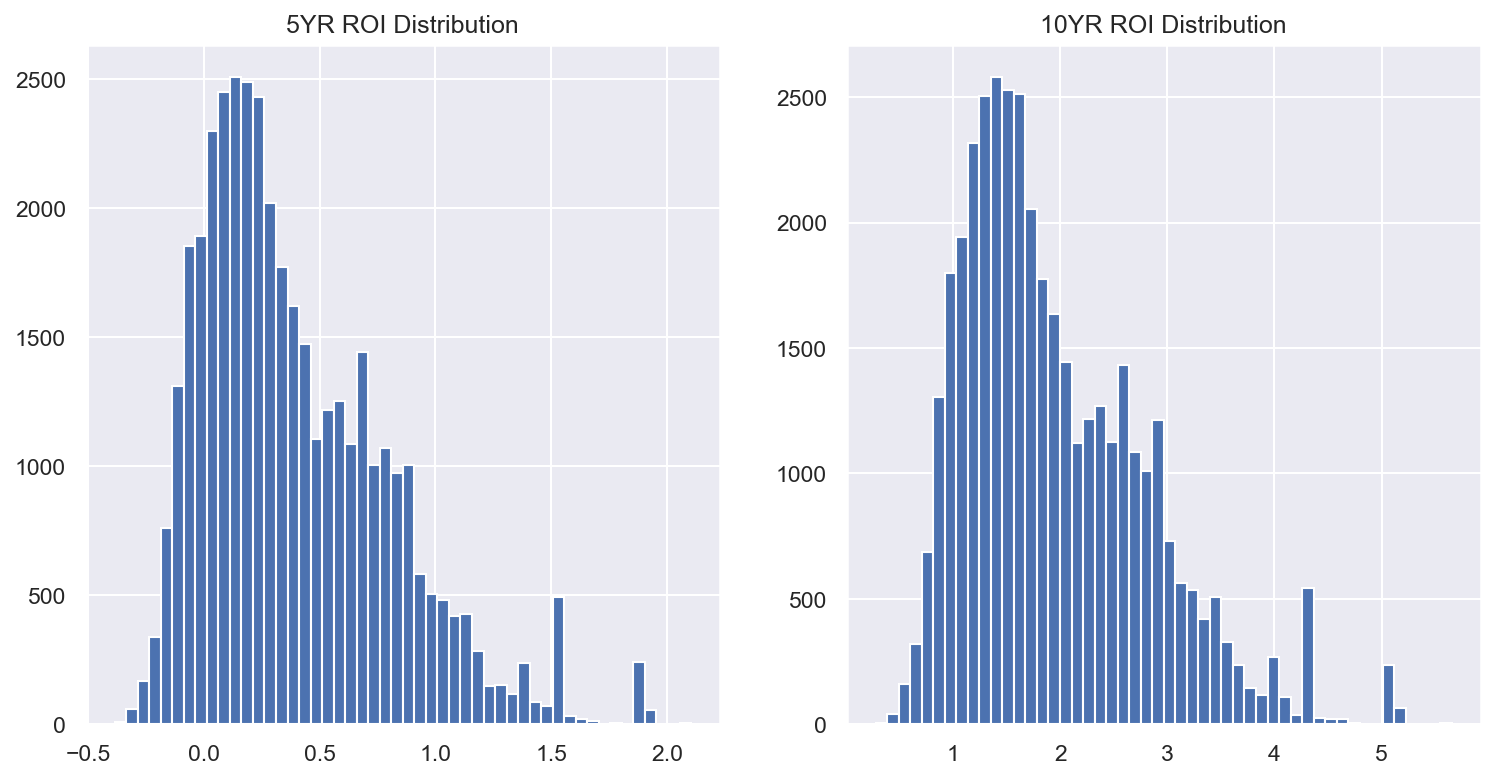

In [37]:
# side-by-side comparison

plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

plt.subplot(121)
plt.title("5YR ROI Distribution")
plt.hist(train_imputed["roi_5yr"], bins = 50)

plt.subplot(122)
plt.title("10YR ROI Distribution")
plt.hist(train_imputed["roi_10yr"], bins = 50)

plt.show()

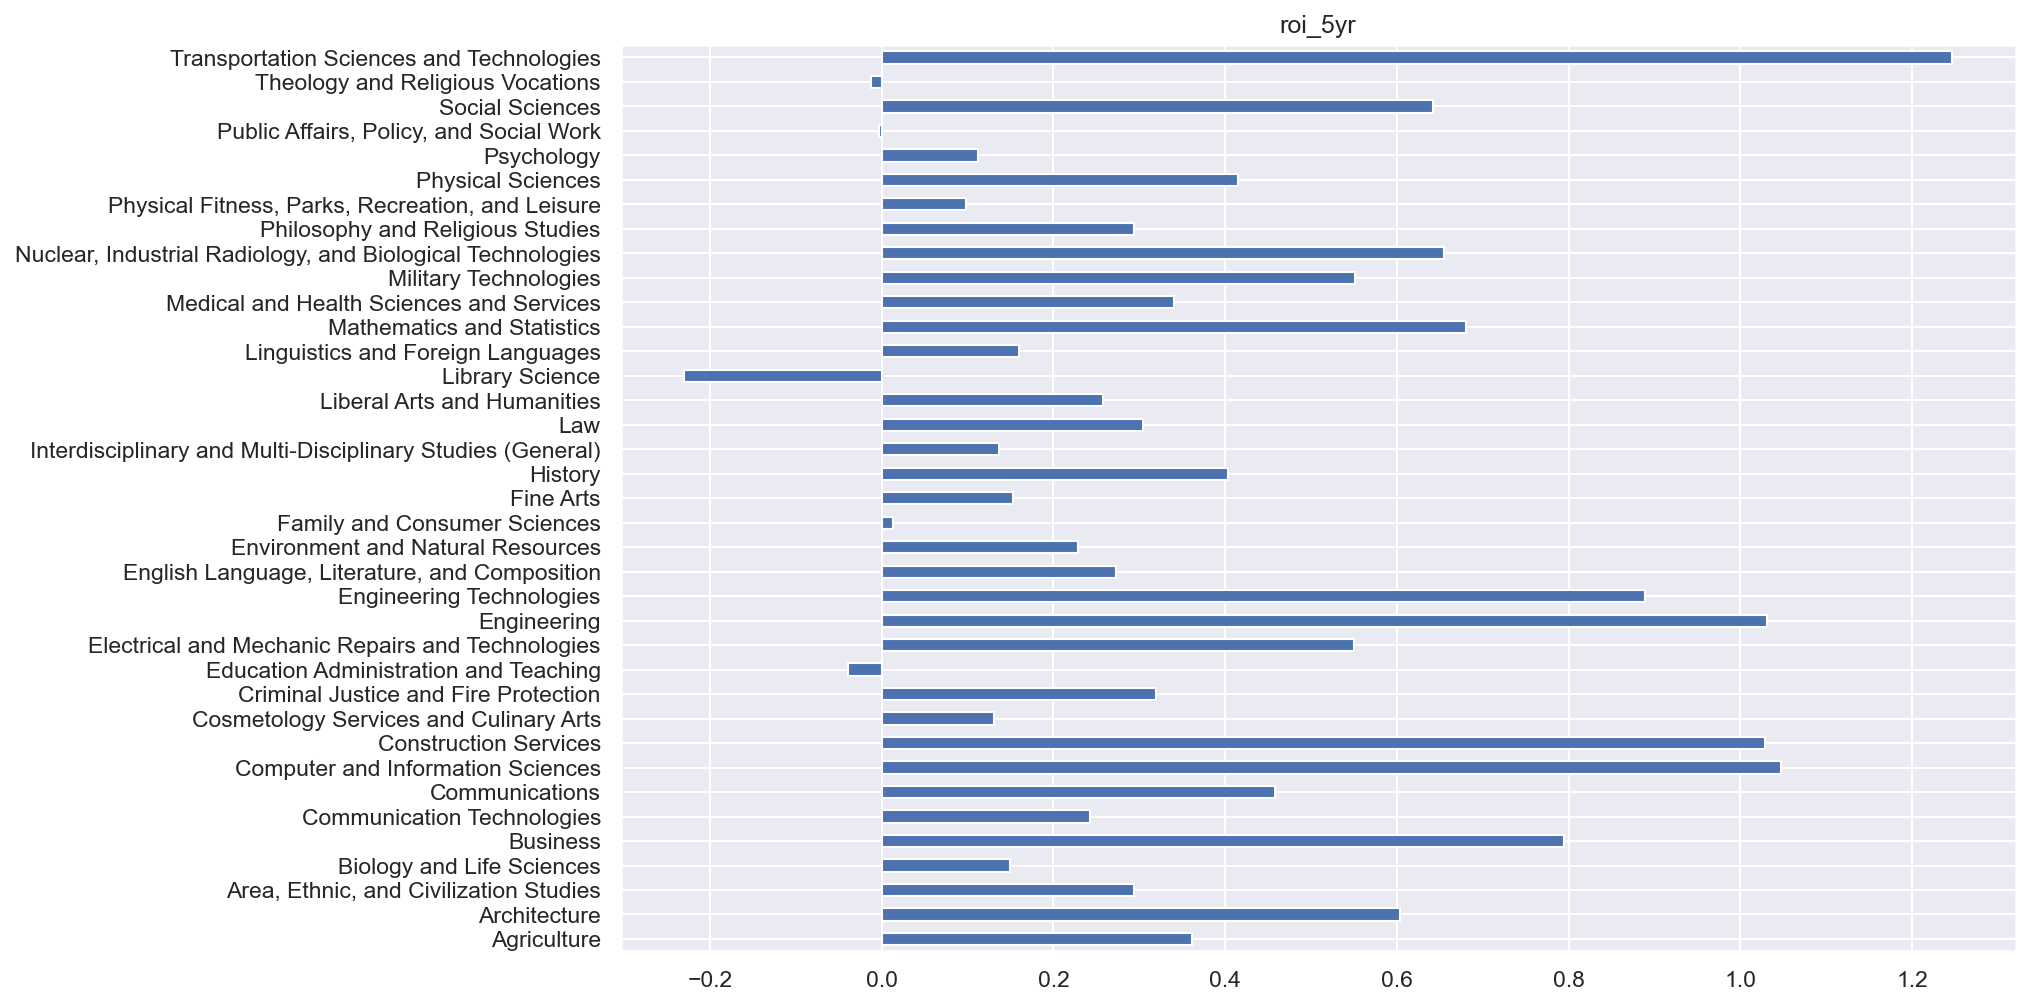

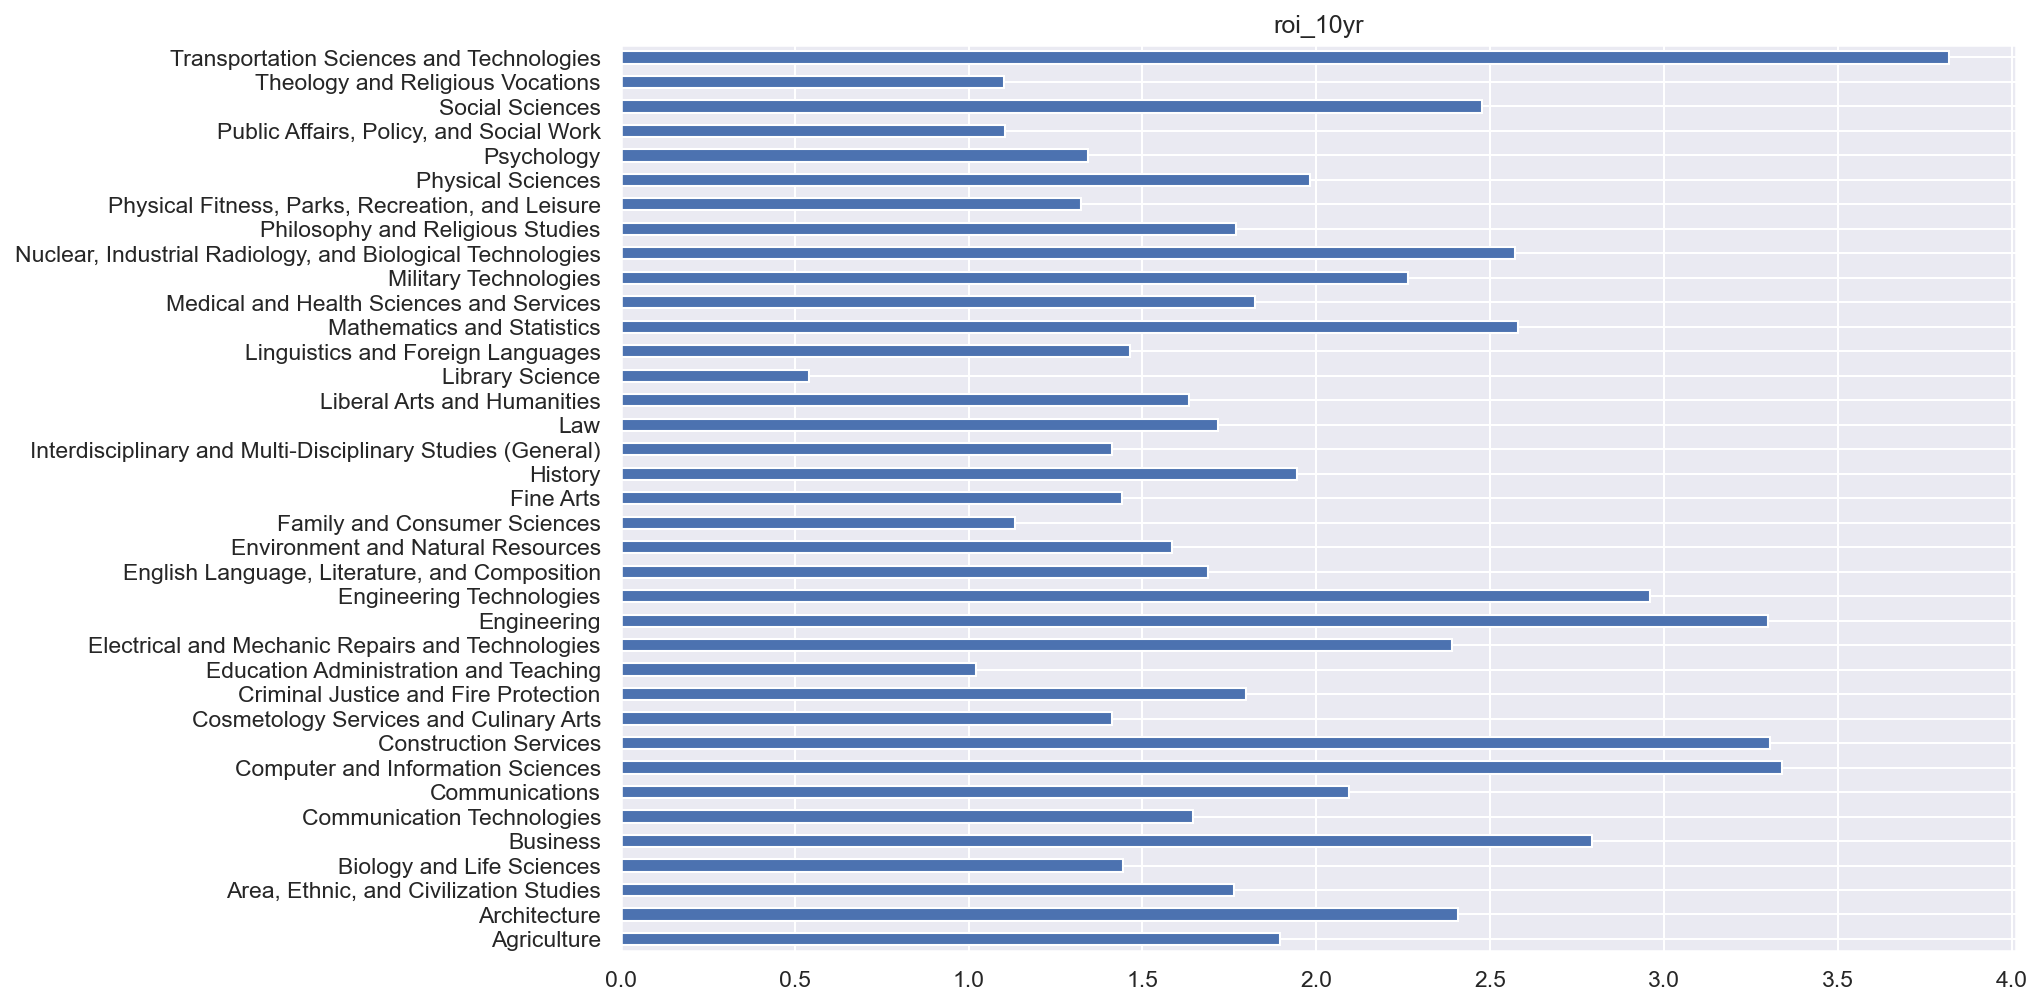

In [38]:
# are majors statistically significant in determining 5/10yr ROI
# let's plot major by their 5/10yr ROI Mean

roi_vars = ["roi_5yr", "roi_10yr"]

for i in range(len(roi_vars)):
    plt.figure(figsize = (12,8))

    train_imputed.groupby(
        ["major_category"])[roi_vars[i]].mean().plot(
                                                    kind = "barh")

    plt.ylabel(None)
    plt.title(roi_vars[i])
    plt.show()

**``Hypothesis Question #1:``**

**Is there a difference in ROI earnings across majors?**

Null Hypothesis: "There's not a statistical 5-year Major ROI difference college majors."

Alternative Hypothesis: "There is a statistical 5-year Major ROI difference difference college majors."

----

Null Hypothesis: "There's not a statistical 10-year Major ROI difference college majors."

Alternative Hypothesis: "There is a statistical 10-year Major ROI difference difference college majors."


alpha: 0.05

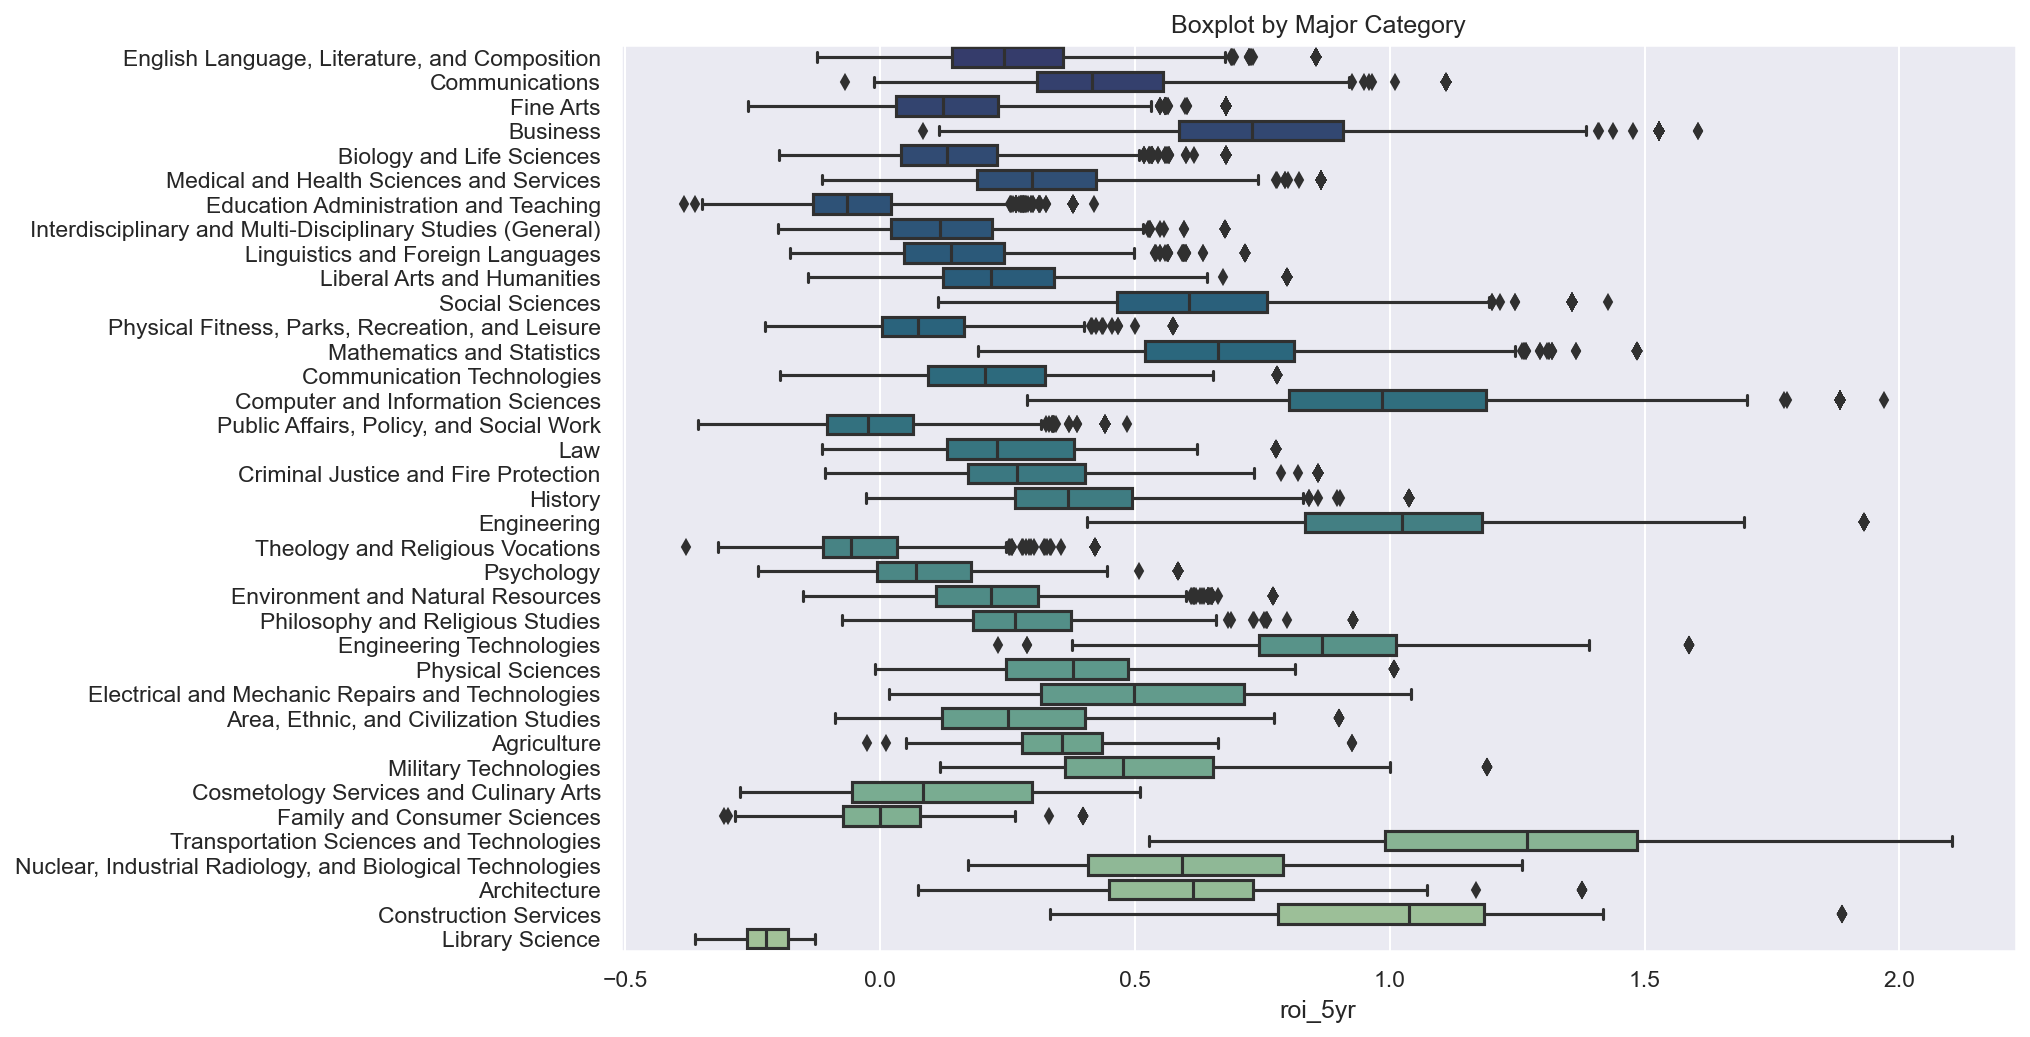

In [39]:
# bar plot?
plt.figure(figsize = (12, 8))

sns.boxplot(
    x = "roi_5yr",
    y = "major_category",
    data = train_imputed,
    orient = "h",
    palette = "crest_r"
)

plt.title("Boxplot by Major Category")
plt.ylabel(None)
plt.show()

In [40]:
majors_lst = train_imputed["major_category"].unique().tolist()
text = "train_imputed[train_imputed[major_category] == "

container = []

for major in majors_lst:
    # concat/add major name to code string
    new_text = text + "'" + major + "'" + "]['roi_5yr'].values,"
    container.append(new_text)

# for ele in container:
#     print(ele)

In [41]:
# majors_lst = train_imputed["'major_category'"].unique().tolist()

f_statistic, p_value = stats.f_oneway(
                    train_imputed[train_imputed['major_category'] == 'English Language, Literature, and Composition']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Communications']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Fine Arts']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Business']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Biology and Life Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Medical and Health Sciences and Services']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Education Administration and Teaching']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Interdisciplinary and Multi-Disciplinary Studies (General)']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Linguistics and Foreign Languages']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Liberal Arts and Humanities']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Social Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Physical Fitness, Parks, Recreation, and Leisure']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Mathematics and Statistics']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Communication Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Computer and Information Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Public Affairs, Policy, and Social Work']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Law']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Criminal Justice and Fire Protection']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'History']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Engineering']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Theology and Religious Vocations']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Psychology']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Environment and Natural Resources']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Philosophy and Religious Studies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Engineering Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Physical Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Electrical and Mechanic Repairs and Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Area, Ethnic, and Civilization Studies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Agriculture']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Military Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Cosmetology Services and Culinary Arts']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Family and Consumer Sciences']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Transportation Sciences and Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Nuclear, Industrial Radiology, and Biological Technologies']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Architecture']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Construction Services']['roi_5yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Library Science']['roi_5yr'].values
)

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 2151.30737
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


In [42]:
# what about 10 yr ROI?

f_statistic, p_value = stats.f_oneway(
                    train_imputed[train_imputed['major_category'] == 'English Language, Literature, and Composition']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Communications']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Fine Arts']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Business']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Biology and Life Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Medical and Health Sciences and Services']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Education Administration and Teaching']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Interdisciplinary and Multi-Disciplinary Studies (General)']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Linguistics and Foreign Languages']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Liberal Arts and Humanities']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Social Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Physical Fitness, Parks, Recreation, and Leisure']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Mathematics and Statistics']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Communication Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Computer and Information Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Public Affairs, Policy, and Social Work']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Law']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Criminal Justice and Fire Protection']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'History']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Engineering']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Theology and Religious Vocations']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Psychology']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Environment and Natural Resources']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Philosophy and Religious Studies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Engineering Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Physical Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Electrical and Mechanic Repairs and Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Area, Ethnic, and Civilization Studies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Agriculture']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Military Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Cosmetology Services and Culinary Arts']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Family and Consumer Sciences']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Transportation Sciences and Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Nuclear, Industrial Radiology, and Biological Technologies']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Architecture']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Construction Services']['roi_10yr'].values,
                    train_imputed[train_imputed['major_category'] == 'Library Science']['roi_10yr'].values
)

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 2157.76609
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


**``Observations:``**

- There appears to be a statistical significance across the college major categories and the 5-10yr ROI

----

**``Hypothesis Question #2: ``**

**Is there a difference in ROI earnings across public/private/’other’ controlled institutions?**

Null Hypothesis: "There's not a statistical 5-year Major ROI difference across institution control."

Alternative Hypothesis: "There is a statistical 5-year Major ROI difference difference across institution control."

--
<br>

Null Hypothesis: "There's not a statistical 10-year Major ROI difference across institution control."

Alternative Hypothesis: "There is a statistical 10-year Major ROI difference difference across institution control."


alpha: 0.05

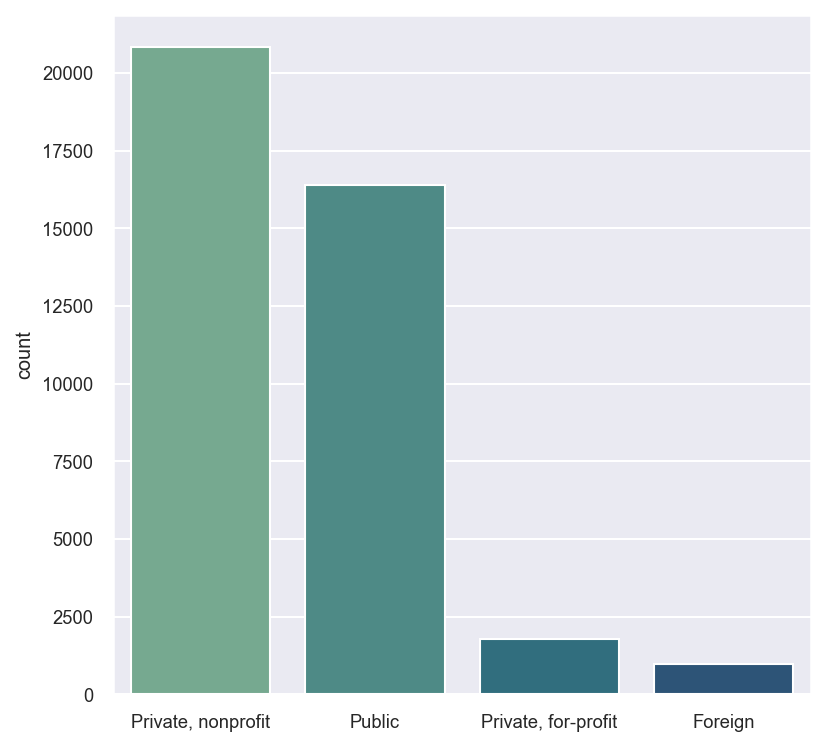

In [43]:
# viewing institution control by the numbers

plt.figure(figsize=(6, 6))
sns.set(font_scale = .8)

sns.countplot(
    train_imputed["institution_control"],
    order = train_imputed["institution_control"].value_counts().index,
    palette="crest")

plt.xlabel(None)
plt.show()

In [44]:
# observations 
# private - non for profit wins out with most records in the training dataset
# where foreign is the least number of observations

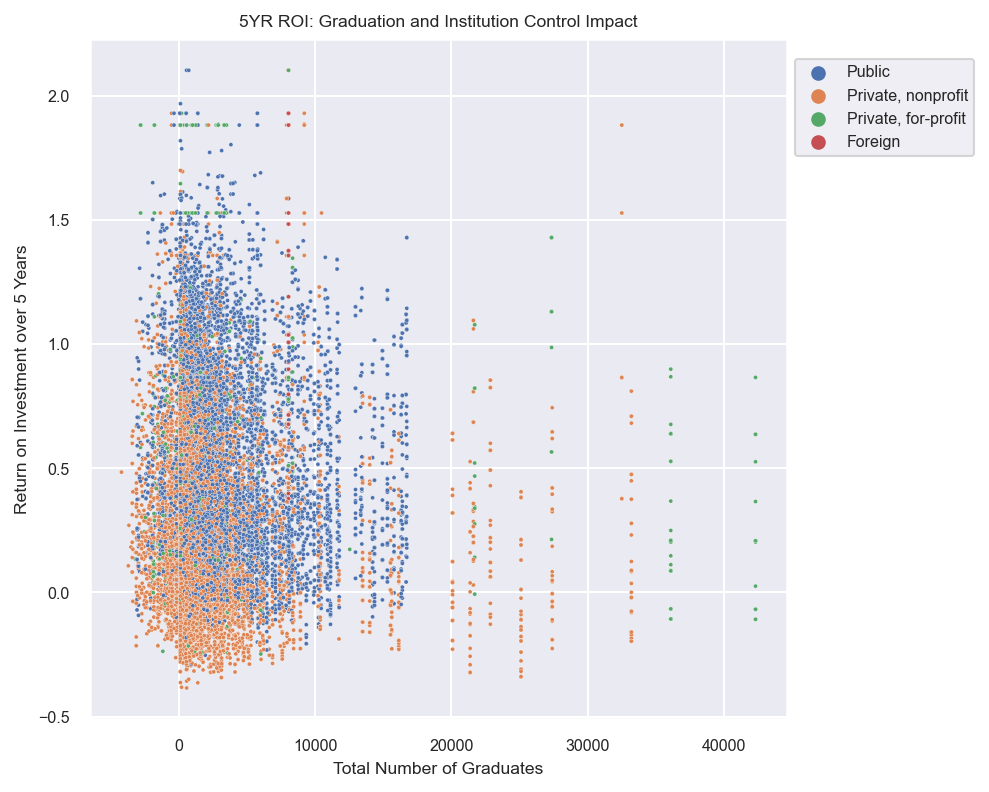

In [45]:
# plotting institution control type by 5_year ROI

plt.figure(figsize = (6, 6))
sns.set(font_scale = 0.7)

g = sns.scatterplot( 
    x = train_imputed["graduate_number"],
    y = train_imputed["roi_5yr"],
    data = train_imputed,
    hue = train_imputed["institution_control"],
    s = 4
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.9), ncol=1)
plt.title("5YR ROI: Graduation and Institution Control Impact")
plt.xlabel("Total Number of Graduates")
plt.ylabel("Return on Investment over 5 Years")
plt.show()

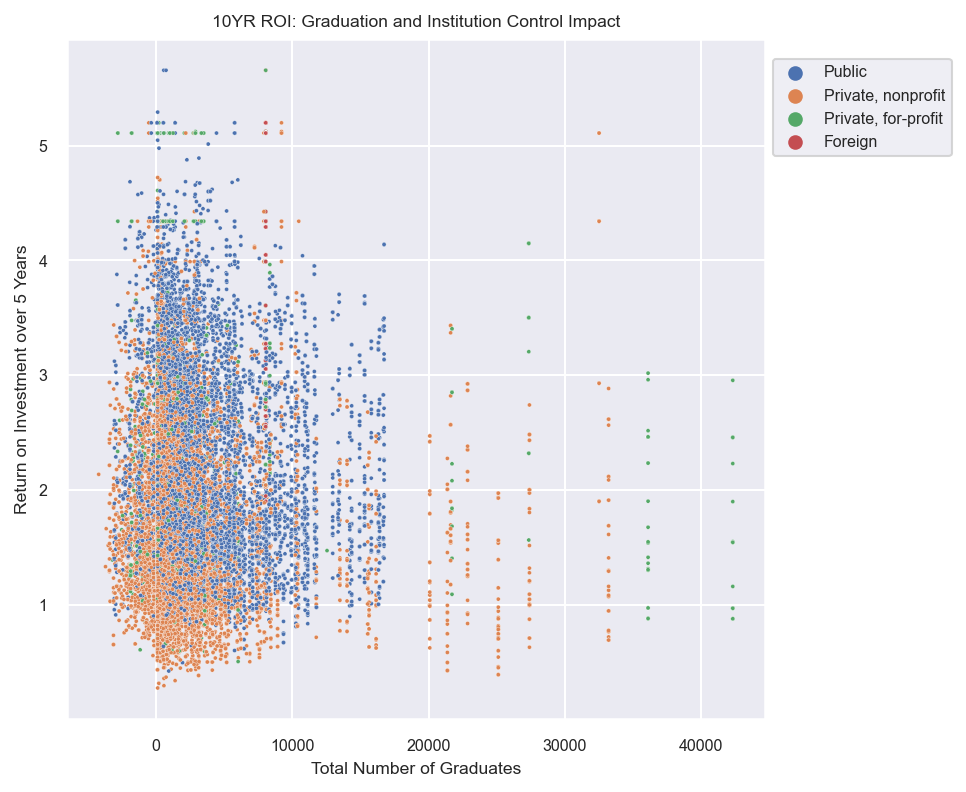

In [46]:
# plotting institution control type by 10_year ROI

plt.figure(figsize = (6, 6))
sns.set(font_scale = 0.7)

# data = train_imputed[train_imputed["graduate_number"] > 0]

g = sns.scatterplot( 
    x = train_imputed["graduate_number"],
    y = train_imputed["roi_10yr"],
    data = train_imputed[train_imputed["graduate_number"] > 0],
    hue = train_imputed["institution_control"],
    s = 4
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.9), ncol=1)
plt.title("10YR ROI: Graduation and Institution Control Impact")
plt.xlabel("Total Number of Graduates")
plt.ylabel("Return on Investment over 5 Years")
plt.show()

In [47]:
# 5YR/major average capture

majors = train_imputed["major_category"].unique().tolist()

pub_container = []
pri_profit_container = []
pri_nonprofit_container = []
forein_container = []

for major in majors:
    
    pub_values = train_imputed[(train_imputed["institution_control"] == "Public") & (train_imputed["major_category"] == major)]["roi_5yr"].values
    pri_profit_values = train_imputed[(train_imputed["institution_control"] == "Private, for-profit") & (train_imputed["major_category"] == major)]["roi_5yr"].values
    pri_nonprofit_values = train_imputed[(train_imputed["institution_control"] == "Private, nonprofit") & (train_imputed["major_category"] == major)]["roi_5yr"].values
    foreign_values = train_imputed[(train_imputed["institution_control"] == "Foreign") & (train_imputed["major_category"] == major)]["roi_5yr"].values

    # extend values
    pub_container.extend(pub_values)
    pri_profit_container.extend(pri_profit_values)
    pri_nonprofit_container.extend(pri_nonprofit_values)
    forein_container.extend(foreign_values)

print(f'length: {len(pub_container)}')
print(f'length: {len(pri_profit_container)}')
print(f'length: {len(pri_nonprofit_container)}')
print(f'length: {len(forein_container)}')

length: 16389
length: 1786
length: 20834
length: 986


In [48]:
# ANOVA hypothesis test for: institution control

f_statistic, p_value = stats.f_oneway(
    pub_container,
    pri_profit_container,
    pri_nonprofit_container,
    forein_container
    )

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 2896.39108
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


In [49]:
# 10yr/major average capture

majors = train_imputed["major_category"].unique().tolist()

pub_container = []
pri_profit_container = []
pri_nonprofit_container = []
forein_container = []

for major in majors:
    pub_mean = train_imputed[(train_imputed["institution_control"] == "Public") & (train_imputed["major_category"] == major)]["roi_10yr"].values
    pri_profit_mean = train_imputed[(train_imputed["institution_control"] == "Private, for-profit") & (train_imputed["major_category"] == major)]["roi_10yr"].values
    pri_nonprofit_mean = train_imputed[(train_imputed["institution_control"] == "Private, nonprofit") & (train_imputed["major_category"] == major)]["roi_10yr"].values
    foreign_mean = train_imputed[(train_imputed["institution_control"] == "Foreign") & (train_imputed["major_category"] == major)]["roi_10yr"].values

    # extend values
    pub_container.extend(pub_mean)
    pri_profit_container.extend(pri_profit_mean)
    pri_nonprofit_container.extend(pri_nonprofit_mean)
    forein_container.extend(foreign_mean)

print(f'length: {len(pub_container)}')
print(f'length: {len(pri_profit_container)}')
print(f'length: {len(pri_nonprofit_container)}')
print(f'length: {len(forein_container)}')

length: 16389
length: 1786
length: 20834
length: 986


In [50]:
# ANOVA hypothesis test for: institution control

f_statistic, p_value = stats.f_oneway(
    pub_container,
    pri_profit_container,
    pri_nonprofit_container,
    forein_container
    )

alpha = 0.05

# comparing the p_value to alpha
print(f'f statistic = {f_statistic.round(5)}')
print(f'p value = {p_value.round(5)}')
print("-----------------")

if p_value < alpha:
    print('We reject the null hypothesis. Means are different across the groups.')
else:
    print('We fail to reject the null hypothesis. Means are similar across the groups.')

f statistic = 2874.30396
p value = 0.0
-----------------
We reject the null hypothesis. Means are different across the groups.


``observations:``

A college's institutional control is statistically significant in potentially predicting a student's 5 and 10 year ROI

In [51]:
pd.set_option("display.max_columns", None)
train_imputed[train_imputed["graduate_number"] < 0.0].head()

# where graduate_number == "graduate students"
# choosing to leave this variable

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,deg_percent_awarded_agriculture_operations,deg_percent_awarded_natural_resources,deg_percent_awarded_architecture,deg_percent_awarded_area_ethnic_cultural_gender,deg_percent_awarded_communication_journalism,deg_percent_awarded_communication_tech,deg_percent_awarded_computer_science,deg_percent_awarded_personal_culinary_services,deg_percent_awarded_education,deg_percent_awarded_engineering,deg_percent_awarded_engineering_tech,deg_percent_awarded_foreign_language_literatures,deg_percent_awarded_human_science,deg_percent_awarded_legal_profession,deg_percent_awarded_english_lang,deg_percent_awarded_general_studies,deg_percent_awarded_library_sciences,deg_percent_awarded_bio_sciences,deg_percent_awarded_mathematics,deg_percent_awarded_military_tech,deg_percent_awarded_intedisciplinary_studies,deg_percent_awarded_leisure_fitness,deg_percent_awarded_philosophy,deg_percent_awarded_theology,deg_percent_awarded_physical_sciences,deg_percent_awarded_science_tech,deg_percent_awarded_psychology,deg_percent_awarded_homeland_security,deg_percent_awarded_public_admin,deg_percent_awarded_social_sciences,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,comp_rt_ft_150over_expected_time_two_races,comp_rt_ft_150over_expected_time_native_american,comp_rt_ft_150over_expected_time_asian,comp_rt_ft_150over_expected_time_black,comp_rt_ft_150over_expected_time_hispanic,comp_rt_ft_150over_expected_time_non_resident,comp_rt_ft_150over_expected_time_unknown_race,comp_rt_ft_150over_expected_time_white,comp_rt_ft_150over_expected_time,enrollment_share_two_races,enrollment_share_native_american,enrollment_share_asian,enrollment_share_black,enrollment_share_hispanic,enrollment_share_pac_islander,enrollment_share_non_resident,enrollment_share_unknown,enrollment_share_white,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
1948,Berea College,"Private, nonprofit",40404-2182,0.8866,0.0099,1.000000,"Foods, Nutrition, and Related Services.",0.0,-976.431085,0.0328,0.0000,0.0,0.0147,0.0525,0.0,0.0721,0.0,0.0393,0.0000,0.0449,0.0197,0.0508,0.0,0.0549,0.0000,0.0,0.0984,0.0197,0.0,0.0230,0.0328,0.0131,0.0,0.0295,0.0,0.0590,0.0,0.0,0.0787,0.0,0.0,0.0,0.0,0.0721,0.0361,0.0852,0.0131,0.25930,0.000000,0.750000,0.5614,0.7368,0.961500,0.750000,0.6389,0.6282,0.0681,0.0012,0.0270,0.1613,0.1196,0.0006,0.0755,0.0080,0.5387,0.2967,0.7920,Biology and Life Sciences,48851.90913,50004.54091,53463.29170,152319.7417,1964.0,0.599134,2.397976,256.0,95.0,56.0,2.0,0.0
35520,Marlboro College,"Private, nonprofit",05344-0300,0.8444,0.0099,3.000000,Sociology.,0.0,-931.023136,0.0000,0.0344,0.0,0.0147,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0549,0.0370,0.0,0.0185,0.0000,0.0,0.0000,0.0000,0.0204,0.0,0.0370,0.0,0.0370,0.0,0.0,0.1794,0.0,0.0,0.0,0.0,0.1089,0.0000,0.0643,0.0345,1.00000,0.631187,0.333300,1.0000,0.9733,1.000000,0.875000,0.5714,0.6250,0.0214,0.0007,0.0286,0.0429,0.0295,0.0000,0.0214,0.1153,0.7286,0.6071,0.5357,Social Sciences,69607.02668,70888.91524,74486.23755,214982.1795,17497.0,0.628395,2.446395,13.0,4.0,3.0,1.0,5.0
64452,Eckerd College,"Private, nonprofit",33711-4700,0.9340,0.0312,1.000000,Research and Experimental Psychology.,0.0,-1548.080638,0.0000,0.0344,0.0,0.0147,0.0247,0.0,0.0206,0.0,0.0000,0.0021,0.0000,0.0000,0.0000,0.0,0.0267,0.0226,0.0,0.1462,0.0103,0.0,0.0082,0.0000,0.0041,0.0,0.0226,0.0,0.1204,0.0,0.0,0.0782,0.0,0.0,0.0,0.0,0.0288,0.0000,0.1770,

In [52]:
# what about the share of first time - full time students by major?

train_imputed[train_imputed["major_category"] == "Agriculture"]["share_entering_students_first_ft"].mean()

0.7380679104477605

In [53]:
s = train_imputed.groupby(["major_category"])["share_entering_students_first_ft"].mean()
s = s.sort_values(ascending = False)

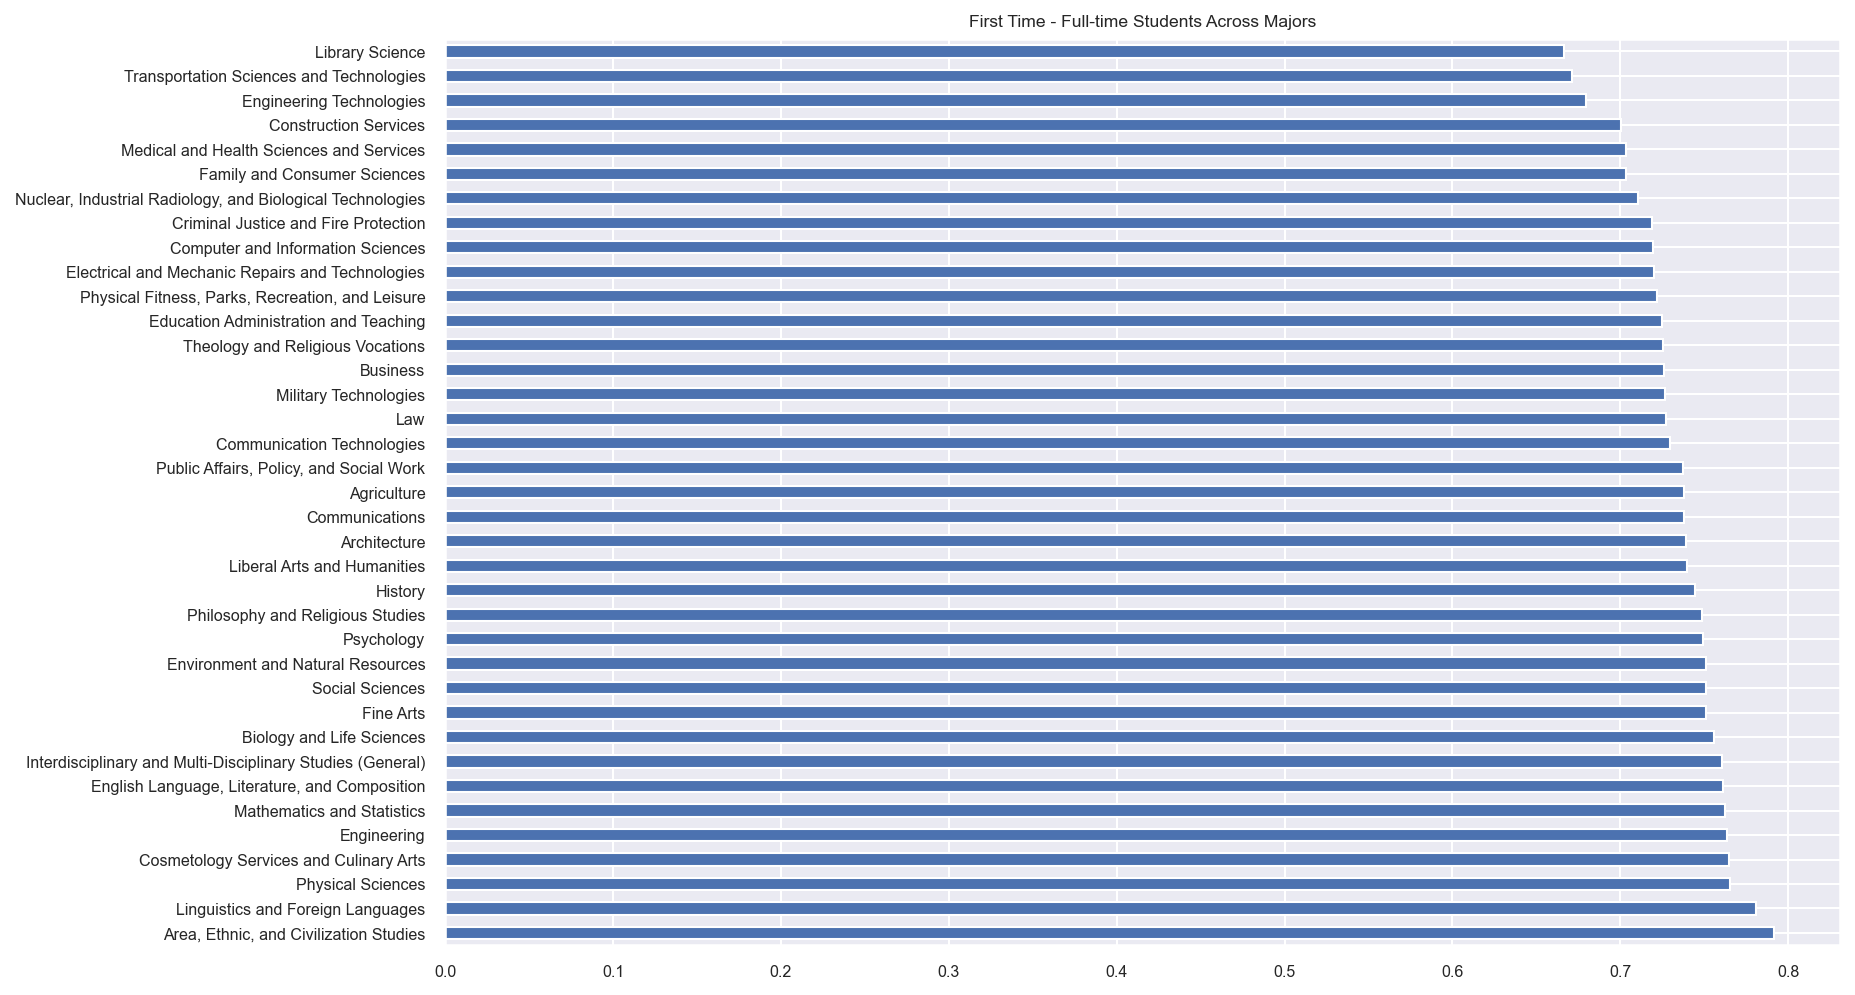

In [54]:
# plotting first-time - full-time student average by major

plt.figure(figsize = (12,8))
s.plot(kind = "barh")

plt.title("First Time - Full-time Students Across Majors")
plt.ylabel(None)
plt.show()

In [55]:
# function to iterate and print major syntax for hypothesis testing

# def print_major_syntax(train_df):
#     majors_lst = train_df["major_category"].unique().tolist()
#     text1 = "train_imputed[(train_imputed['major_category'] == "
#     text2 = "(train_imputed['share_entering_students_first_ft'])]['roi_5yr'].values,"

#     container = []

#     for major in majors_lst:
#         # concat/add major name to code string
#         new_text = text + "'" + major + "'" + "]['roi_5yr'].values,"
#         container.append(new_text)

#     return container

In [56]:
# shape check

train_imputed.shape

(39995, 80)

In [58]:
# creating bins of 'first-time, full-time student rates'
# "rate of full time students by major"
# (0.47, 0.623] < (0.623, 0.753] < (0.753, 0.871] < (0.871, 0.962)

train_imputed['share_entering_ft_binned'] = pd.qcut(
    train_imputed['share_entering_students_first_ft'], \
    q = 4, \
    labels = ["below_average", "average", "above_average", "highest_average"])

train_imputed.head() # checks out

,college_name,institution_control,zip_code,share_entering_students_first_ft,share_of_part_time,required_score,major_name,online_only,graduate_number,deg_percent_awarded_agriculture_operations,deg_percent_awarded_natural_resources,deg_percent_awarded_architecture,deg_percent_awarded_area_ethnic_cultural_gender,deg_percent_awarded_communication_journalism,deg_percent_awarded_communication_tech,deg_percent_awarded_computer_science,deg_percent_awarded_personal_culinary_services,deg_percent_awarded_education,deg_percent_awarded_engineering,deg_percent_awarded_engineering_tech,deg_percent_awarded_foreign_language_literatures,deg_percent_awarded_human_science,deg_percent_awarded_legal_profession,deg_percent_awarded_english_lang,deg_percent_awarded_general_studies,deg_percent_awarded_library_sciences,deg_percent_awarded_bio_sciences,deg_percent_awarded_mathematics,deg_percent_awarded_military_tech,deg_percent_awarded_intedisciplinary_studies,deg_percent_awarded_leisure_fitness,deg_percent_awarded_philosophy,deg_percent_awarded_theology,deg_percent_awarded_physical_sciences,deg_percent_awarded_science_tech,deg_percent_awarded_psychology,deg_percent_awarded_homeland_security,deg_percent_awarded_public_admin,deg_percent_awarded_social_sciences,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,comp_rt_ft_150over_expected_time_two_races,comp_rt_ft_150over_expected_time_native_american,comp_rt_ft_150over_expected_time_asian,comp_rt_ft_150over_expected_time_black,comp_rt_ft_150over_expected_time_hispanic,comp_rt_ft_150over_expected_time_non_resident,comp_rt_ft_150over_expected_time_unknown_race,comp_rt_ft_150over_expected_time_white,comp_rt_ft_150over_expected_time,enrollment_share_two_races,enrollment_share_native_american,enrollment_share_asian,enrollment_share_black,enrollment_share_hispanic,enrollment_share_pac_islander,enrollment_share_non_resident,enrollment_share_unknown,enrollment_share_white,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,major_category,2017,2018,2019,Grand Total,avg_net_price,roi_5yr,roi_10yr,fam_income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000,share_entering_ft_binned
25530,University of Memphis,Public,38152,0.6227,0.2274,1.0,Journalism.,0.0,4225.0,0.0000,0.0000,0.0029,0.0022,0.0481,0.0000,0.0099,0.0,0.0471,0.0430,0.0134,0.0127,0.0000,0.0000,0.0248,0.0554,0.0,0.0258,0.0067,0.0,0.0811,0.0825,0.0022,0.0000,0.0201,0.0,0.0542,0.0440,0.0245,0.0395,0.0,0.0,0.0,0.0,0.0347,0.1112,0.1816,0.0127,0.405100,0.500000,0.754400,0.3585,0.5357,0.6471,0.500000,0.5405,0.4780,0.0398,0.0021,0.0364,0.3650,0.0563,0.0006,0.0170,0.0117,0.4703,0.5540,0.5491,"English Language, Literature, and Composition",54382.32187,57100.39013,58348.57445,169831.2865,13048.0,0.391327,1.937021,559.0,300.0,248.0,186.0,209.0,average
53875,Limestone University,"Private, nonprofit",29340-3799,0.5654,0.2116,1.0,Communication and Media Studies.,0.0,106.0,0.0000,0.0000,0.0000,0.0000,0.0067,0.0000,0.0809,0.0,0.0472,0.0000,0.0000,0.0000,0.0017,0.0000,0.0118,0.0641,0.0,0.0371,0.0034,0.0,0.0000,0.0405,0.0000,0.0000,0.0000,0.0,0.0540,0.0725,0.0664,0.0000,0.0,0.0,0.0,0.0,0.0320,0.0641,0.3238,0.0118,0.500000,0.000000,0.461567,0.2712,0.4615,0.6471,0.200000,0.3613,0.3514,0.0110,0.0066,0.0060,0.3650,0.0360,0.0000,0.0360,0.0154,0.4517,0.8371,0.5478,Communications,61311.56178,63458.16253,66997.75002,191767.4743,24083.0,0.305598,1.770293,106.0,51.0,57.0,39.0,49.0,below_average
42932,Texas State University,Public,78666,0.6166,0.1797,1.0,Design and Applied Arts.,0.0,4457.0,0.0122,0.0139,0.0025,0.0000,0.0816,0.0011,0.0369,0.0,0.0000,0.0235,0.0194,0.0081,0.0298,0.0000,0.0376,0.0192,0.0,0.0403,0.0081,0.0,0.0811,0.0790,0.0025,0.0000,0.0049,0.0,0.0